In [1]:
%matplotlib widget

from gqlalchemy import Memgraph
import pymongo

from matplotlib import pyplot as plt
from tqdm import tqdm
import json
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np


In [2]:

# Make a connection to the database
memgraph = Memgraph(host="localhost", port=7687)

# Make a connection to the database
def get_mongo_db():
    client = pymongo.MongoClient("mongodb://localhost:27017")
    db = client["brain"]
    return db

db = get_mongo_db()
db_calcium = db["calcium_neurons"]
db_no_network = db["no_network_neurons"]


In [3]:
query = "MATCH (n:Neuron:Calcium) RETURN n.x as x, n.y as y, n.z as z, n.id as id"
results = memgraph.execute_and_fetch(query)
neurons = []
for neuron in results:
    neurons.append(neuron)

df = pd.DataFrame(neurons)
df.set_index("id", inplace=True)

df = df.assign(comm1=np.nan, comm2=np.nan, comm3=np.nan)
df

,x,y,z,comm1,comm2,comm3
id,,,,,,
4,88.066131,143.973540,83.238470,NaN,NaN,NaN
1,88.071787,143.792200,83.237149,NaN,NaN,NaN
2,88.093434,143.951900,83.168331,NaN,NaN,NaN
6,88.074268,143.940950,83.318852,NaN,NaN,NaN
17,88.177126,144.003350,81.224019,NaN,NaN,NaN
...,...,...,...,...,...,...
44088,37.168906,14.491207,75.343971,NaN,NaN,NaN
44866,40.333663,12.520083,73.653373,NaN,NaN,NaN
45092,109.600110,13.579520,41.659956,NaN,NaN,NaN


In [4]:
cursor = db_no_network.find({"step":0}, {"_id": 0, "neuron_id": 1, "community_granularity_1": 1, "community_granularity_2": 1, "community_granularity_3": 1})
print(df.loc[df.index == 0])
for result in tqdm(cursor, total=50000):
    df.loc[df.index == result["neuron_id"], "comm1"] = result["community_granularity_1"]
    df.loc[df.index == result["neuron_id"], "comm2"] = result["community_granularity_2"]
    df.loc[df.index == result["neuron_id"], "comm3"] = result["community_granularity_3"]

print(df.loc[df.index == 0])


            x          y          z  comm1  comm2  comm3
id                                                      
0   88.017654  143.88911  83.259131    NaN    NaN    NaN


100%|██████████| 50000/50000 [01:34<00:00, 531.16it/s]

            x          y          z  comm1  comm2  comm3
id                                                      
0   88.017654  143.88911  83.259131    1.0   23.0  247.0


In [52]:
kmeans = KMeans(n_clusters=10).fit(df[["x", "y", "z"]])
centroids = kmeans.cluster_centers_

/home/theo/.local/share/virtualenvs/dis-gRFrr5sP/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [53]:
df["comm1"] = kmeans.labels_
df

,x,y,z,comm1,comm2,comm3
id,,,,,,
10,88.256278,143.932380,81.273889,1,86.0,1753.0
1,88.071787,143.792200,83.237149,1,86.0,1748.0
6,88.074268,143.940950,83.318852,1,86.0,1748.0
7,87.973951,143.881820,83.321619,1,86.0,1748.0
8,88.072210,143.883400,83.284350,1,86.0,1748.0
...,...,...,...,...,...,...
48172,111.657780,7.837576,74.080144,0,234.0,4706.0
47372,61.834296,6.600186,103.229490,4,267.0,5375.0
49305,102.224210,4.915986,78.000952,0,271.0,5448.0


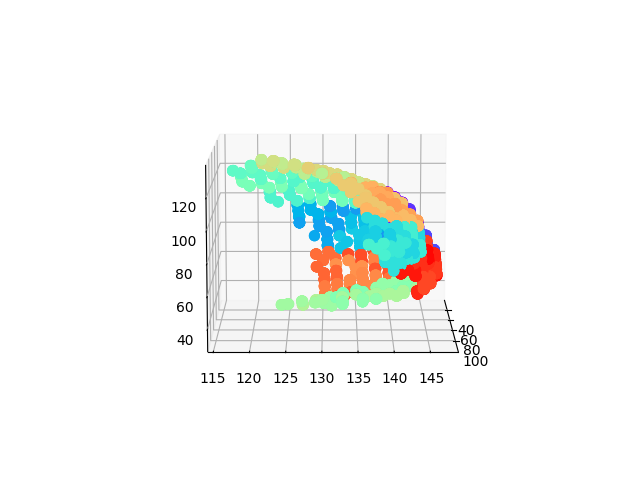

In [12]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10., azim=0.0)
subset = df[df["comm1"] == 1]
ax.scatter(subset["x"], subset["y"], subset["z"], c=subset["comm3"].astype(float), cmap="rainbow", s=50, alpha=1)
# ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c="red", s=50)
plt.show()

In [54]:
for i, label in enumerate(set(df["comm1"])):
    comm = df[df["comm1"] == label]
    labels = KMeans(n_clusters=10, n_init="auto").fit(comm[["x", "y", "z"]]).labels_
    unique_labels = 10 + i * 10 + labels
    df.loc[df["comm1"] == label, "comm2"] = unique_labels

df
    

,x,y,z,comm1,comm2,comm3
id,,,,,,
10,88.256278,143.932380,81.273889,1,23.0,1753.0
1,88.071787,143.792200,83.237149,1,23.0,1748.0
6,88.074268,143.940950,83.318852,1,23.0,1748.0
7,87.973951,143.881820,83.321619,1,23.0,1748.0
8,88.072210,143.883400,83.284350,1,23.0,1748.0
...,...,...,...,...,...,...
48172,111.657780,7.837576,74.080144,0,10.0,4706.0
47372,61.834296,6.600186,103.229490,4,56.0,5375.0
49305,102.224210,4.915986,78.000952,0,17.0,5448.0


In [35]:
# index in df.iterrows of neuron_id 82
df.sort_index(inplace=True)

df

,x,y,z,comm1,comm2,comm3
id,,,,,,
0,88.017654,143.889110,83.259131,1.0,23.0,247.0
1,88.071787,143.792200,83.237149,1.0,23.0,247.0
2,88.093434,143.951900,83.168331,1.0,23.0,247.0
3,88.063898,143.819810,83.317563,1.0,23.0,247.0
4,88.066131,143.973540,83.238470,1.0,23.0,247.0
...,...,...,...,...,...,...
49995,86.890937,1.931412,79.944581,4.0,50.0,519.0
49996,86.764390,1.834104,80.037049,4.0,50.0,519.0
49997,86.699561,1.970323,79.967185,4.0,50.0,519.0


In [ ]:
for i, (neuron_id, series) in tqdm(enumerate(df.iterrows()), total=50000):
    query = {
        "neuron_id": neuron_id,
    }
    newvalues = {
        "$set": {
            "community_granularity_1": int(series["comm1"]),
            "community_granularity_2": int(series["comm2"]),
            "community_granularity_3": int(series["comm3"]),
        }
    }
    result = db_calcium.update_many(query, newvalues)

